# О данном ноутбуке

Этот ноутбук к проекту [Ford vs Ferrari](https://www.kaggle.com/c/sf-dl-car-classification).

Цели проекта:
*   изучить реальную задачу компьютерного зрения на практике (можно будет добавить в портфолио)
*   продолжать учиться программировать: с каждым днем практики ваш код становится лучше, а вы становитесь опытнее

In [1]:
# проверяем, что видеокарта подключена
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-a1fcd914-9893-ee5e-bddb-fd6df7b42c33)


In [2]:
# подготавливаем данные
!mkdir /kaggle/temp #папка для временных файлов
!unzip -q -o /kaggle/input/sf-dl-car-classification/train.zip -d /kaggle/temp
!unzip -q -o /kaggle/input/sf-dl-car-classification/test.zip -d /kaggle/temp

In [3]:
# выгрузим версии установленных библиотек
!pip freeze > 'requirements.txt'

In [4]:
# импорты
import os, re, math, random, time, gc, string, pickle, shutil, pathlib, itertools, sys
import numpy as np, pandas as pd, matplotlib.pyplot as plt, PIL
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm
from keras.models import load_model

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


# Настройки

In [5]:
# for model
EPOCHS               = 12 #best 12
BATCH_SIZE           = 12 #best 12
VAL_SPLIT            = 0.05 #best 0.05
IMG_SIZE             = 520 #best 520
IMG_CHANNELS         = 3
INPUT_SHAPE          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# for augmentation
WIDTH_SHIFT_RANGE    = 0.1
HEIGHT_SHIFT_RANGE   = 0.1
HORIZONTAL_FLIP      = True
VERTICAL_FLIP        = False
ROTATION_RANGE       = 10
BRIGHTNES_RANGE      = (0.5, 1.5)
RESCALE              = 1
SHEAR_RANGE          = 0.2
ZOOM_RANGE           = 0.1

# path to files
PATH = '/kaggle/'
INPUT_PATH = PATH+'input/sf-dl-car-classification/'
DATA_PATH = PATH+'temp/'
TRAIN_PATH = DATA_PATH+'train/'
SUB_PATH = DATA_PATH+'test_upload/'

# seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = '0'
# rn.seed(RANDOM_SEED)

# EDA / Анализ данных

In [6]:
sample_submission = pd.read_csv(INPUT_PATH+'sample-submission.csv')
sample_submission.head()

,Id,Category
0,305108.jpg,0
1,295075.jpg,0
2,31197.jpg,0
3,93598.jpg,0
4,87877.jpg,0


In [7]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6675 entries, 0 to 6674
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        6675 non-null   object
 1   Category  6675 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 104.4+ KB


In [8]:
train_df = pd.read_csv(INPUT_PATH+'train.csv')
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [10]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

<AxesSubplot:>

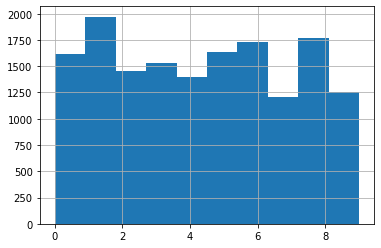

In [11]:
train_df.Category.hist()

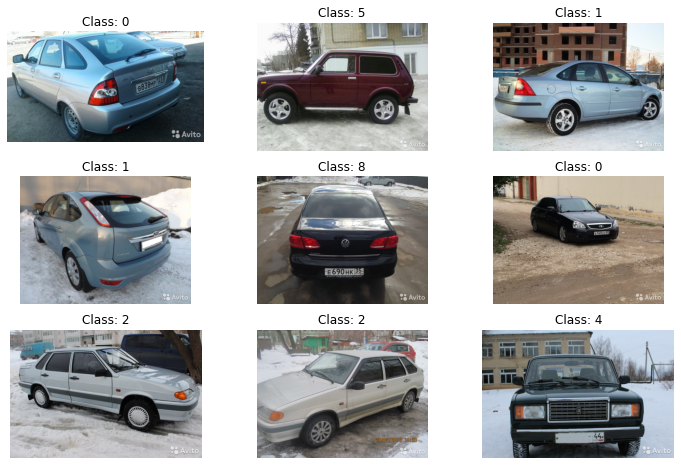

In [12]:
plt.figure(figsize=(12,8))
random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values
for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(TRAIN_PATH+f'{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

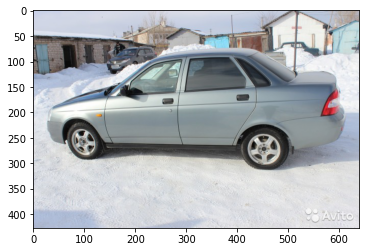

(640, 427)

In [13]:
image = PIL.Image.open(TRAIN_PATH+'/0/100155.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Предварительные итоги:

- Для классификации представлены фотографии 10 категорий авто VAZ, Volkswagen, Ford
- Категории достаточно сбалансированны по кол-ву фото
- Размеры фотографий различаются, но в основном 640 на 480. Цветные.
- Всего 22236 фото в том числе: 15561 в трейне и 6675 в тесте
- Кол-во фото в трейне не достаточно для хорошего обучения модели нейронной сети, поэтому будем применять различные виды аугментации данных

# Обработка данных

In [14]:
# def grayscale(picture):
#     res= Image.new(picture.mode, picture.size)
#     width, height = picture.size
#     for i in range(0, width):
#         for j in range(0, height):
#             pixel=picture.getpixel((i,j))
#             avg=(pixel[0]+pixel[1]+pixel[2])/3
#             res.putpixel((i,j),(int(avg),int(avg),int(avg)))
#     res.show()
#     return res


# def normalize(picture):
#     width, height = picture.size
#     normalized_array = []
#     for j in range(0, height):
#         for i in range(0, width):
#             pixel = picture.getpixel((i,j))
#             normalized_array.append( pixel[0] / 255.0 )
#     return np.array(normalized_array)

In [15]:
# # model from here: https://github.com/ashislaha/CarDetection-Keras
# model = load_model('/kaggle/input/car-detection-model/car_detection_keras_CNN_model.h5')

In [16]:
# # почистим train
# step_num = 0
# remove_num = 0
# for i in range(10):
#     dir_from = f'{TRAIN_PATH}{i}/'
#     files = os.listdir(dir_from)
#     for file in files:
#         step_num += 1
#         img = Image.open(dir_from+file)
#         row,column = 100,100
#         img = img.resize((row,column),Image.ANTIALIAS)
#         try:
#             gray_image = grayscale(img)
#         except:
#             print(f"{file} is not checked")
#             continue
#         X_test = normalize(gray_image)
#         X_test = X_test.reshape(1, row, column, 1)
#         classes = model.predict(X_test)
#         maxVal = classes[0].max()
#         indexVal = np.where(classes[0]==maxVal)
#         if (indexVal[0] == 0):
#             # print(f"{file} is a Car")
#             pass
#         else:
#             os.remove(dir_from+file)
#             remove_num += 1
#             # print(f"{file} is not a Car")
#         if step_num % 10000  == 0:
#             print(f'{step_num} files were checked')
# print(f'{remove_num} files were deleted')

# Добавляем новые данные

В train не так много данных, поэтому я дополнительно написал парсер для скачивания изображений автомобилей указанных моделей с сайта auto.ru:
https://colab.research.google.com/drive/1_FkevD5wB9e9WuBJiajuLROMgSGP3uSL?usp=sharing

Чтобы отделить изображения с автомобилями от изображений салона, документов и пр., использовал модель с github:
https://github.com/ashislaha/CarDetection-Keras

Данные загрузил в отдельный датасет, который потом подключил к текущему ноутбуку. Ссылка на датасет:
https://www.kaggle.com/mukaseevru/autoru

Обработать все изображения не хватает квоты в 10 часов GPU, поэтому для обучения использую только 10000 изображений в каждом классе.

Добавляем эти данные в наш train

In [17]:
# # !find /kaggle/input/cardetection-0-1/0/ -type f -iname "*.jpg" -exec cp {} /kaggle/temp/train/0/ \; 
# !ls -1 /kaggle/input/cardetection-0-1/0/ | xargs -i cp /kaggle/input/cardetection-0-1/0/{} /kaggle/temp/train/0/
# !ls -1 /kaggle/input/cardetection-0-1/1/ | xargs -i cp /kaggle/input/cardetection-0-1/1/{} /kaggle/temp/train/1/
# !ls -1 /kaggle/input/cardetection-2-4/2/ | xargs -i cp /kaggle/input/cardetection-2-4/2/{} /kaggle/temp/train/2/
# !ls -1 /kaggle/input/cardetection-2-4/3/ | xargs -i cp /kaggle/input/cardetection-2-4/3/{} /kaggle/temp/train/3/
# !ls -1 /kaggle/input/cardetection-2-4/4/ | xargs -i cp /kaggle/input/cardetection-2-4/4/{} /kaggle/temp/train/4/
# !ls -1 /kaggle/input/cardetection-5-7/5/ | xargs -i cp /kaggle/input/cardetection-5-7/5/{} /kaggle/temp/train/5/
# !ls -1 /kaggle/input/cardetection-5-7/6/ | xargs -i cp /kaggle/input/cardetection-5-7/6/{} /kaggle/temp/train/6/
# !ls -1 /kaggle/input/cardetection-5-7/7/ | xargs -i cp /kaggle/input/cardetection-5-7/7/{} /kaggle/temp/train/7/
# !ls -1 /kaggle/input/cardetection-8-9/8/ | xargs -i cp /kaggle/input/cardetection-8-9/8/{} /kaggle/temp/train/8/
# !ls -1 /kaggle/input/cardetection-8-9/9/ | xargs -i cp /kaggle/input/cardetection-8-9/9/{} /kaggle/temp/train/9/

# Аугментация

In [18]:
train_datagen = ImageDataGenerator(
#     rescale=1. / 255,
    validation_split=VAL_SPLIT,
    width_shift_range = WIDTH_SHIFT_RANGE,
    height_shift_range = HEIGHT_SHIFT_RANGE,
    horizontal_flip=HORIZONTAL_FLIP,
    rotation_range=ROTATION_RANGE,
    shear_range=SHEAR_RANGE,
    brightness_range=BRIGHTNES_RANGE,
    zoom_range=ZOOM_RANGE,
    vertical_flip=VERTICAL_FLIP,
)

val_datagen = ImageDataGenerator(
#     rescale=1. / 255,
    validation_split=VAL_SPLIT,
)

sub_datagen = ImageDataGenerator(
#     rescale=1. / 255,
    width_shift_range=WIDTH_SHIFT_RANGE, 
    height_shift_range=HEIGHT_SHIFT_RANGE,
    horizontal_flip=HORIZONTAL_FLIP
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    subset='validation'
)

sub_generator = sub_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=SUB_PATH,
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)
# Без дополнительных изображений
# Found 12452 images belonging to 10 classes.
# Found 3109 images belonging to 10 classes.
# Found 6675 validated image filenames.

Found 14788 images belonging to 10 classes.
Found 773 images belonging to 10 classes.
Found 6675 validated image filenames.


Train:


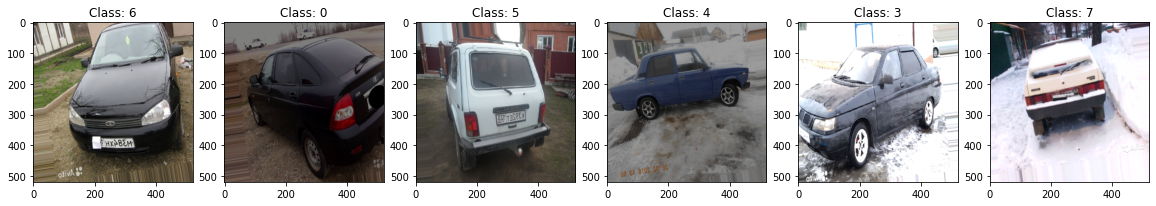

Val:


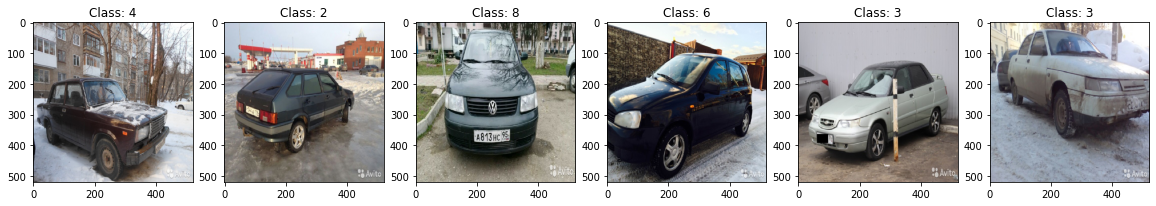

Sub:


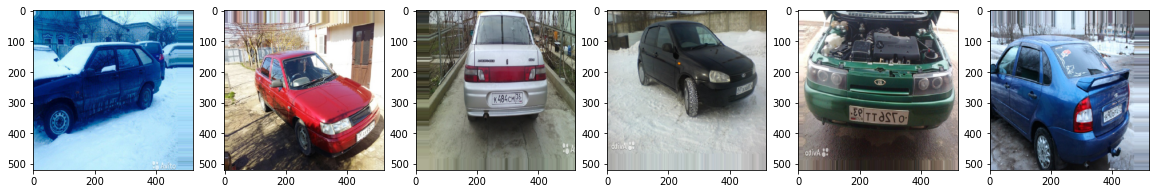

In [19]:
def show_first_images(generator, count=6, labels=True, figsize=(20, 5), normalized=False):
    generator = itertools.islice(generator, count)
    fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
    for batch, ax in zip(generator, axes):
        if labels:
            img_batch, labels_batch = batch
            img, label = img_batch[0], np.argmax(labels_batch[0]) #берем по одному изображению из каждого батча
        else:
            img_batch = batch
            img = img_batch[0]
        if not normalized:
#             img = img.astype(np.float)
            img = img.astype(np.uint8)
        ax.imshow(img)
        # метод imshow принимает одно из двух:
        # - изображение в формате uint8, яркость от 0 до 255
        # - изображение в формате float, яркость от 0 до 1
        if labels:
            ax.set_title(f'Class: {label}')
    plt.show()

    
print('Train:')
show_first_images(train_generator)
print('Val:')
show_first_images(val_generator)
print('Sub:')
show_first_images(sub_generator, labels=False)

In [20]:
# base_model = Xception(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE) #95.37%
# base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE) #95.75%
# base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE) #10.00% IMG_SIZE = 331
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE) #96.14% #97.54 with big picture
# base_model.summary()

43941888/43941136 [==============================] - 0s 0us/step


In [21]:
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation = 'relu')(x)
x = BatchNormalization()(x)
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=ExponentialDecay(0.001, decay_steps=100, decay_rate=0.9)),
              metrics='accuracy')

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.25)(x)
# x = BatchNormalization()(x)
# predictions = Dense(10, activation='softmax')(x)
# model = Model(inputs=base_model.input, outputs=predictions)
# model.compile(loss='categorical_crossentropy',
#               optimizer=optimizers.Adam(learning_rate=ExponentialDecay(0.001, decay_steps=100, decay_rate=0.9)),
#               metrics='accuracy')

# model.summary()

In [22]:
mcheckpoint = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=1, mode='max', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
es = EarlyStopping(monitor='val_loss', patience=5)
callbacks_list = [mcheckpoint, es]

In [23]:
history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator, 
        validation_steps=len(val_generator),
        epochs=EPOCHS,
        callbacks=callbacks_list
)

Epoch 1/12
1233/1233 [==============================] - 1583s 1s/step - loss: 1.0473 - accuracy: 0.6649 - val_loss: 0.1659 - val_accuracy: 0.9560

Epoch 00001: val_accuracy improved from -inf to 0.95602, saving model to best_model.hdf5
Epoch 2/12
1233/1233 [==============================] - 1568s 1s/step - loss: 0.1544 - accuracy: 0.9464 - val_loss: 0.1194 - val_accuracy: 0.9702

Epoch 00002: val_accuracy improved from 0.95602 to 0.97025, saving model to best_model.hdf5
Epoch 3/12
1233/1233 [==============================] - 1585s 1s/step - loss: 0.0929 - accuracy: 0.9667 - val_loss: 0.1160 - val_accuracy: 0.9702

Epoch 00003: val_accuracy did not improve from 0.97025
Epoch 4/12
1233/1233 [==============================] - 1611s 1s/step - loss: 0.0677 - accuracy: 0.9752 - val_loss: 0.1184 - val_accuracy: 0.9715

Epoch 00004: val_accuracy improved from 0.97025 to 0.97154, saving model to best_model.hdf5
Epoch 5/12
1233/1233 [==============================] - 1626s 1s/step - loss: 0.0751

In [24]:
model.save('last_model.hdf5')
model.load_weights('best_model.hdf5')

In [25]:
scores = model.evaluate(val_generator, steps=len(val_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
os.rename('best_model.hdf5', f'best_model_{round(scores[1]*100, 2)}.hdf5')

65/65 [==============================] - 12s 182ms/step - loss: 0.1184 - accuracy: 0.9715
Accuracy: 97.15%


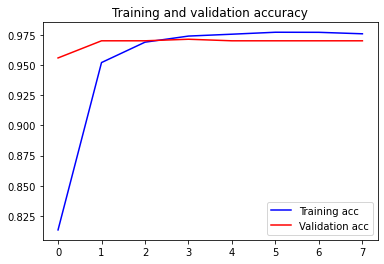

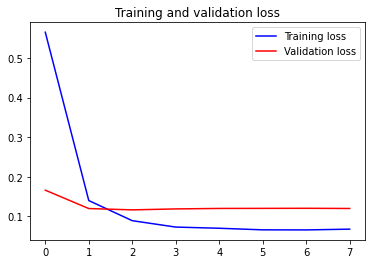

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Сделаем файл для сабмита:

In [27]:
predictions = model.predict(sub_generator, verbose=1).argmax(axis=1)
submission = pd.DataFrame({
    'Id': sub_generator.filenames,
    'Category': predictions
}, columns=['Id', 'Category'])
submission.to_csv('submission.csv', index=False)

557/557 [==============================] - 442s 790ms/step


# TTA
Попытаемся улучшить метрику.

In [28]:
sub_generator.reset()
predictions_tta = []
for _ in range(EPOCHS):
    predictions_tta.append(model.predict(sub_generator, verbose=1))
    sub_generator.reset()
predictions_tta = np.mean(np.array(predictions_tta), axis=0).argmax(axis=1)
submission_tta = pd.DataFrame({
    'Id': sub_generator.filenames,
    'Category': predictions_tta
}, columns=['Id', 'Category'])
submission_tta.to_csv('submission_tta.csv', index=False)

557/557 [==============================] - 424s 761ms/step


# Ансамблирование
Возьмем ансабль из лучшей и последней модели. Больший вес отдадим лучшей модели, т.к. у нее лучшая метрика.

In [29]:
model_2 = load_model('last_model.hdf5')
sub_generator.reset()
predictions_tta_ansemble = []
for _ in range(EPOCHS):
    predictions_tta_ansemble.append(0.6*model.predict(sub_generator, verbose=1) \
                                    + 0.2*model_2.predict(sub_generator, verbose=1))
    sub_generator.reset()
predictions_tta_ansemble = np.mean(np.array(predictions_tta_ansemble), axis=0).argmax(axis=1)
submission_tta_ansemble = pd.DataFrame({
    'Id': sub_generator.filenames,
    'Category': predictions_tta_ansemble
}, columns=['Id', 'Category'])
submission_tta_ansemble.to_csv('submission_tta_ansemble.csv', index=False)

557/557 [==============================] - 436s 783ms/step


# Результаты:
!!! На полный ноутбук не хватает квоты в 10 часов GPU процессора
1. Лучшая метрика в соревновании kaggle: 0.97063
2. Ссылка на проект на github: https://github.com/mukaseevru/skillfactory_rds/tree/master/module_7
3. Что можно сделать дополнительно (не хватило времени):
- обратить внимание на ошибки в классах 7 и 9, т.к. автомобили внешне очень похожи
- обработать выбросы
- разметить test, добавить в train и обучить
- сделать больше тестов с различными параметрами
- уравнять классы
- разделить процесс обучения на части продолжительностью менее 10 часов

# Если вам понравился этот ноутбук, пожалуйста, поставьте **апвойт***
*Это кнопка со стрелкой. Расположена она ниже под горизонтальной линией.

# If you like my notebook please click **upvote***
*It's the up arrow button. It's located further under the horizontal line.